   TradeID Commodity TradeType  Volume   Price Currency DeliveryStart  \
0        1     Power       BUY  193.52  191.13      GBP    2025-01-08   
1        2       Gas       BUY  368.68  127.76      GBP    2025-01-29   
2        3     Power      SELL   86.45   48.08      USD    2025-01-03   
3        4       Gas       BUY   38.46  175.91      GBP    2025-01-23   
4        5      Coal       BUY  304.55  147.45      EUR    2025-01-09   

  DeliveryEnd Periodicity  
0  2025-01-16     Monthly  
1  2025-02-16   Quarterly  
2  2025-01-10       Daily  
3  2025-02-13       Daily  
4  2025-02-04   Quarterly  
Index(['TradeID', 'Commodity', 'TradeType', 'Volume', 'Price', 'Currency',
       'DeliveryStart', 'DeliveryEnd', 'Periodicity'],
      dtype='object')

Dataset 1 shape: (100, 9)
TradeID            int64
Commodity         object
TradeType         object
Volume           float64
Price            float64
Currency          object
DeliveryStart     object
DeliveryEnd       object
Periodicity   

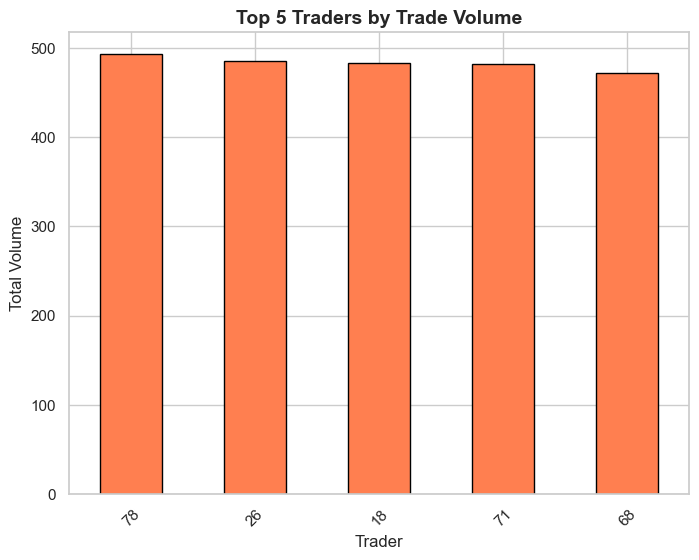

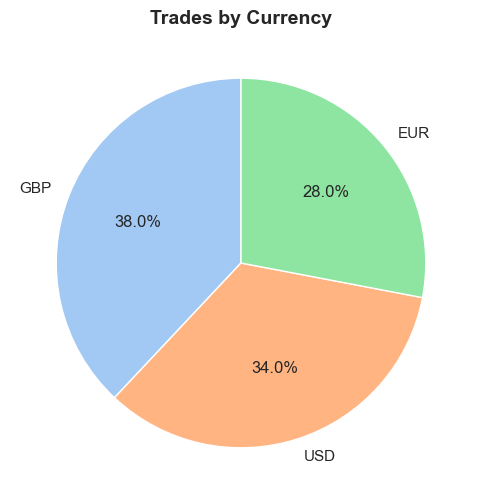

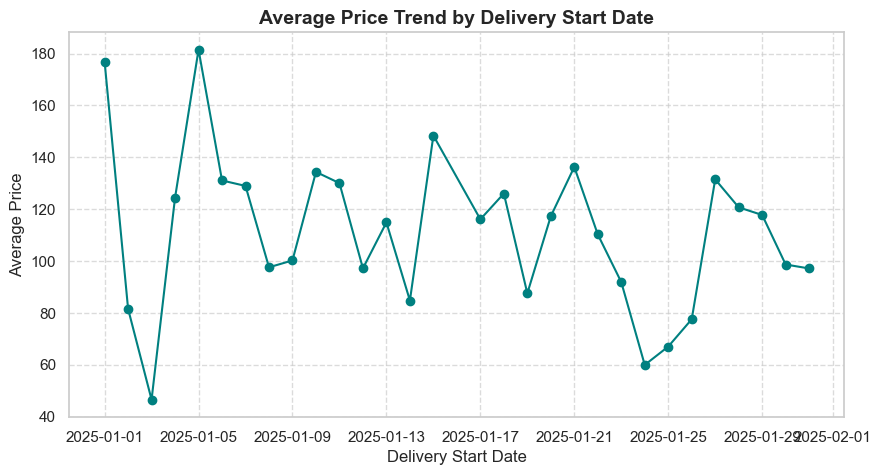

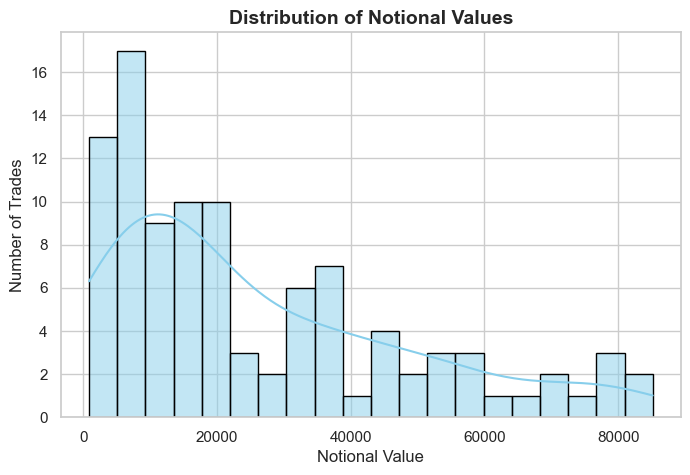

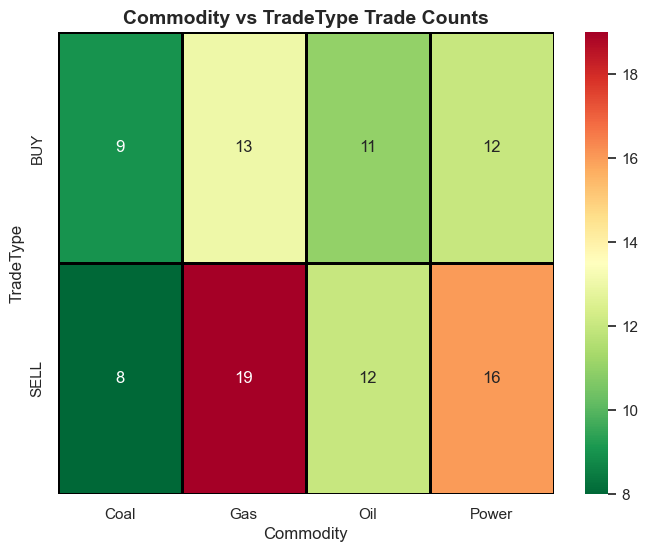

In [8]:
# ---------------------------
# 1. Import Libraries
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from lxml import etree

# point this to your folder
folder = r"C:\Users\EshaP\Downloads\ETRM-Data-Analysis\data"

# load the CSV (or any other format you prefer as the master dataset)
df = pd.read_csv(os.path.join(folder, "etrm_trades.csv"))

print(df.head())   # quick check
print(df.columns)  # confirm columns
# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
# ---------------------------
# 2. Data Ingestion
# ---------------------------
folder = r"C:\Users\EshaP\Downloads\ETRM-Data-Analysis\data"  

# Load CSV
df_csv = pd.read_csv(os.path.join(folder, "etrm_trades.csv"))

# Load JSON
df_json = pd.read_json(os.path.join(folder, "etrm_trades.json"))

# Load Excel
df_excel = pd.read_excel(os.path.join(folder, "etrm_trades.xlsx"))

# Load TXT (pipe-delimited)
df_txt = pd.read_csv(os.path.join(folder, "etrm_trades.txt"), delimiter="|")

# Load HTML (table)
df_html = pd.read_html(os.path.join(folder, "etrm_trades.html"))[0]

# Load XML
def load_xml(path):
    tree = etree.parse(path)
    root = tree.getroot()
    data = []
    for trade in root.findall("Trade"):
        record = {child.tag: child.text for child in trade}
        data.append(record)
    return pd.DataFrame(data)

df_xml = load_xml(os.path.join(folder, "etrm_trades.xml"))
# ---------------------------
# 3. Ensure Consistency
# ---------------------------
dfs = [df_csv, df_json, df_excel, df_txt, df_html, df_xml]
for i, df in enumerate(dfs):
    print(f"\nDataset {i+1} shape: {df.shape}")
    print(df.dtypes)

# Use CSV as the master dataset
df = df_csv.copy()

# ---------------------------
# 4. Data Cleaning & Transformation
# ---------------------------
df["DeliveryStart"] = pd.to_datetime(df["DeliveryStart"])
df["DeliveryEnd"] = pd.to_datetime(df["DeliveryEnd"])

# Convert numeric fields
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Add notional value (Volume * Price)
df["Notional"] = df["Volume"] * df["Price"]

# ---------------------------
# 5. Exploratory Data Analysis
# ---------------------------

# Top 5 traders by trade volume
top_traders = df.groupby("TradeID")["Volume"].sum().sort_values(ascending=False).head(5)
print("Top 5 Traders by Trade Volume:\n", top_traders)

# Average price per commodity
avg_price = df.groupby("Commodity")["Price"].mean()
print("\nAverage Price per Commodity:\n", avg_price)

# Distribution of trades by currency
currency_dist = df["Currency"].value_counts()
print("\nTrades by Currency:\n", currency_dist)

# Trade periodicity breakdown
periodicity = df["Periodicity"].value_counts()
print("\nTrade Periodicity Breakdown:\n", periodicity)

# ---------------------------
# 6. Data Visualization 
# ---------------------------

# Bar chart: Volume by Trader
# Group by Trader and sum the trade volume
top_traders = (
    df.groupby("TradeID")["Volume"]  
    .sum()
    .sort_values(ascending=False)        # sort by total volume
    .head(5)                             # top 5
)

# Plot
plt.figure(figsize=(8,6))
top_traders.plot(
    kind="bar",
    color="coral",
    edgecolor="black"
)

plt.title("Top 5 Traders by Trade Volume", fontsize=14, fontweight="bold")
plt.xlabel("Trader")
plt.ylabel("Total Volume")
plt.xticks(rotation=45)
plt.show()


# Pie chart: Trades by Currency
plt.figure(figsize=(6,6))
currency_dist.plot(
    kind="pie", autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel")
)
plt.title("Trades by Currency", fontsize=14, fontweight="bold")
plt.ylabel("")
plt.show()

# Line chart: Average Price Trend by Delivery Start Date
avg_price_trend = df.groupby("DeliveryStart")["Price"].mean()
plt.figure(figsize=(10,5))
plt.plot(avg_price_trend.index, avg_price_trend.values, marker="o", color="teal")
plt.title("Average Price Trend by Delivery Start Date", fontsize=14, fontweight="bold")
plt.xlabel("Delivery Start Date")
plt.ylabel("Average Price")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Histogram: Distribution of Notional Values
plt.figure(figsize=(8,5))
sns.histplot(df["Notional"], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Distribution of Notional Values", fontsize=14, fontweight="bold")
plt.xlabel("Notional Value")
plt.ylabel("Number of Trades")
plt.show()

# Heatmap: Commodity vs Trader Trade Counts
# Heatmap: Commodity vs TradeType (counts)
pivot = pd.crosstab(df["TradeType"], df["Commodity"])

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    annot=True,       # show numbers inside cells
    fmt="d",          # integer format
    cmap="RdYlGn_r",  # green → yellow → red style
    cbar=True,
    linewidths=1,     # grid lines
    linecolor="black" # box-style look
)

plt.title("Commodity vs TradeType Trade Counts", fontsize=14, fontweight="bold")
plt.xlabel("Commodity")
plt.ylabel("TradeType")
plt.show()




